## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests were conducted for this project in order to understand the results of an A/B test run by an e-commerce website. The goal is to work through the notebook to help the company understand if they should implement the new page, keep the old page.


<a id='probability'></a>
#### Part I - Probability

Import the libraries

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

1. Read in the dataset ab_data.csv and store it in df

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Find the number of rows in the dataset - 294478

In [3]:
df.shape[0]

294478

Find the number of unique users in the dataset - 290584

In [4]:
df['user_id'].nunique()

290584

Find the proportion of users converted

In [5]:
df['converted'].mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't match

In [6]:
not_match1 = df.query('group != "treatment" & landing_page == "new_page"').count()
not_match2 = df.query('group == "treatment" & landing_page != "new_page"').count()
print(not_match1)
print(not_match2)

Not_Match= not_match1 + not_match2
print(Not_Match)

user_id         1928
timestamp       1928
group           1928
landing_page    1928
converted       1928
dtype: int64
user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64
user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64


Check for the missing values in the dataset.
The rows have no missing values

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

Therefore, the new dataset that meets the abovementioned specifications is created and stored in **df2**.

In [8]:
df2 = df.query("(group == 'treatment' and landing_page == 'new_page') or (group == 'control' and landing_page == 'old_page')")

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` The **df2** dataset:

Identify unique **user_id**s in **df2**

In [10]:
df2['user_id'].nunique()

290584

Check for duplicates **user_id**  in **df2**

In [11]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

Find the row information for the repeated **user_id** 

In [12]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Drop one of the duplicated rows

In [13]:
df2.drop_duplicates(subset='user_id', inplace = True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [14]:
#Additional check for the duplicated 'user_id'

df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Using **df2**, checking for the probability 

In [15]:
df2['converted'].mean()

0.11959708724499628

The probability of converted, given that an individual was in the `control` group

In [16]:
c_m = df2['converted'][df2['group'] == 'control'].mean()
c_m 

0.1203863045004612

The probability of converted, given that an individual was in the `treatment` group

In [17]:
t_m = df2['converted'][df2['group'] == 'treatment'].mean()
t_m 

0.11880806551510564

The probability that an individual received the new page

In [18]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

**Observations:** From the results of the data above, the number of individuals in the control and treatment groups who converted is almost the same and equivalent to 11.9% and 12% respectively. Therefore, the results do not provide enough evidence whether the treatment page leads to more conversions. A Hypothesis Testing and p-value calculation are needed in order to provide more information for the decision whether to implement a new page or keep the old. 

<a id='ab_test'></a>
### Part II - A/B Test

The null and alternative hypotheses, if we assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%

**Hypotheses:**



*$$H_0 :  p_{new} - p_{old} \leq 0 \\ $$*

*$$H_1 :   p_{new} - p_{old} \gt  0 \\ $$*


**where:** 
**$p_{old}$** is the converted rate for the old page;
**$p_{new}$** is the converted rate for the new page.



**Conversion rate** for $p_{new}$ under the null 

In [36]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**Conversion rate** for $p_{old}$ under the null

In [37]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

$n_{new}$, the number of individuals in the treatment group

In [38]:
n_new = df2.query("group == 'treatment'").shape[0]
n_new

145310

$n_{old}$, the number of individuals in the control group

In [39]:
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null

In [40]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[p_new, 1-p_new])

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null

In [41]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[p_old, 1-p_old])

Find the difference $p_{new}$ - $p_{old}$ for the simulated values

In [42]:
diff =  new_page_converted.mean() - old_page_converted.mean()
diff

-0.00041111893119927245

Create 10,000 $p_{new}$ - $p_{old}$ values

In [43]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size=n_new, p=[(1-p_new), p_new])
    old_page_converted = np.random.choice([0,1], size=n_old, p=[(1-p_old), p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

In [44]:
np.array(p_diffs)

array([ 0.0007827 , -0.00066963, -0.00085541, ..., -0.00049079,
       -0.00160579,  0.00032834])

Plot a histogram of the **p_diffs**

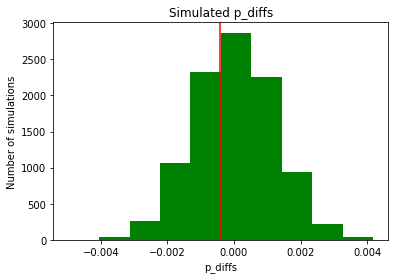

In [45]:
plt.hist(p_diffs, color = 'green')
plt.title('Simulated p_diffs')
plt.xlabel('p_diffs')
plt.ylabel('Number of simulations')
plt.axvline(x=diff, color='red');

Comparing the proportion of the **p_diffs** and the actual difference observed in **ab_data.csv**

In [46]:
act_diff = t_m - c_m
act_diff

-0.0015782389853555567

In [49]:
(p_diffs > act_diff).mean()

0.90959999999999996

**Answer #1 :**

**the value we calculated is p-value which in this case is equal to 90,9%. According to the p-value we cannot reject the Null Hypothesis, which states that the new page is not significantly better than the old page**

We could also use a built-in to achieve similar results

In [50]:
import statsmodels.api as sm

convert_old = sum(df2.query("group=='control'")['converted'])
convert_new = sum(df2.query("group=='treatment'")['converted'])

print(convert_old)
print(convert_new)

n_old = df2.query("landing_page=='old_page'").shape[0]
n_new = df2.query("landing_page=='new_page'").shape[0]
print(n_old)
print(n_new)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


17489
17264
145274
145310


Using `stats.proportions_ztest` to compute the test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) 

In [51]:
from statsmodels.stats.proportion import proportions_ztest

z_score, p_val = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score) 
print(p_val)


-1.31092419842
0.905058312759


**Answer #2 :** 

**z-score = -1,31 and p-value= 0,905 suggest that we fail to reject the Null hypothesis. The results here correspond with the results in j.**

<a id='regression'></a>
### Part III - A regression approach


**Answer #3: Logistic regression**

**As the purpose of the analyses is to estimate the probability of the outcome event (to use the new page or not) - accordnig to the article below - the logistic regression would be the better choice.**

**https://kb.osu.edu/bitstream/handle/1811/23983/V103N5_118.pdf**

The goal here is to use **statsmodels** to fit the regression model we specified above in order to see if there is a significant difference in conversion based on which page a customer receives

First, we create dummy variables

In [52]:
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


Second, we create intercept, instantiate  and fit the model

In [53]:
df2['intercept'] = 1

log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Provide the summary of the model

In [54]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-04 17:53 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**Answer #4:**  

**Here our p-value = 0,1899 is based on the two-tailed test while above (in the code stats.proportions_ztest) we used One-tailed test (alternative='larger') and the p-value= 0,905 was the result. The p-value here remains above the 0,05 threshold level. Therefore, we still failed to reject the Null Hypothesis**

**https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html**

In [55]:
#Additional: the two-tailed test with the code  stats.proportions_ztest from Part II gives the same p-value = 0.1899

from statsmodels.stats.proportion import proportions_ztest

z_score, p_val = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='two-sided')
print(z_score) 
print(p_val)

-1.31092419842
0.189883374482


**Answer #5:**

**The advantages to add other factors into the regression:**

1.Allows to determine the relative influence of one or more predictor variables to the criterion value;

2.Allows to identify the possible outliers.


**The disadvantage:** 

1. The variables can be correlated with each other, producing inaccurate results.

**https://sciencing.com/advantages-disadvantages-multiple-regression-model-12070171.html**

Additionally,  using the second dataset **countries.csv** in order to check whether there is an effect based on which country a user lives in


In [56]:
df3 = pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


Joining tables [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html)

In [57]:
df_new = df3.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [58]:
#Additionally, identifying the countries
df_new['country'].nunique()
df_new.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

Creat the dummy variable for country

In [59]:
country_dummies = pd.get_dummies(df_new['country'])
df_new = df_new.join(country_dummies)
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


Instantiate and fit the model

In [60]:
#Logistic regression only with countries UK and US
df_new['intercept'] = 1
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US']])
results2 = log_mod.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-04 17:55 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

**Results #1:**

The p-values for the countries are above our 0,05 threshold level. 
Therefore, there is no significant effect of the 'country'. We cannot reject the Null Hypothesis.

Although the p-value for the UK (0,074) is close to our threshold level, there is still not enough evidence to reject the null hypothesis.


In [61]:
##Logistic regression with countries UK, US along with testing if the conversion rate changes for different pages
df_new['intercept'] = 1
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US', 'ab_page']])
results3 = log_mod.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-04 17:56 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
==================================================================

"""

**Results #2:**

The p-values for all independent variables are above our 0,05 threshold level. 
Therefore, we again cannot reject the Null Hypothesis.

Check for an interaction

In [62]:
df_new['US_page'] = df_new['US'] * df_new['ab_page']
df_new['UK_page'] = df_new['UK'] * df_new['ab_page']
df_new.head()

,country,timestamp,group,landing_page,converted,ab_page,old_page,intercept,CA,UK,US,US_page,UK_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,1,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1,1,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,1


In [63]:
df_new['intercept'] = 1
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'UK', 'US', 'ab_page', 'US_page', 'UK_page']])
results4 = log_mod.fit()
results4.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-04 17:56 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US_page        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

**Results #3:**

The p-values for all independent variables are above our 0,05 threshold level. Therefore, we again cannot reject the Null Hypothesis.

**Conclusion**

According to the analysis I performed, all results show that none of the variables have significant p-values. As there is no significant impact on conversion, I fail to reject the Null Hypothesis. 

General recomendation: there are not enough sufficient evidences to suggest that the new page results in more conversions than the old page. The company should keep the old page.

**Resources:**
1.	https://stackoverflow.com/questions/50594377/list-rows-which-column-value-is-not-unique-in-dataframe  - List rows which column value is not unique in dataframe
2.	https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html - df.drop_duplicates documentation
3.	https://www.math.ubc.ca/~pwalls/math-python/jupyter/latex/  - LaTeX 
4.	John T. Pohlmann and Dennis W. Leitner, 2003 / „A Comparison of Ordinary Least Squares and Logistic Regression“ / Department of Educational Psychology, Southern Illinois University, Carbondale, IL 62901, p.124 - https://kb.osu.edu/bitstream/handle/1811/23983/V103N5_118.pdf#
5.	https://sciencing.com/advantages-disadvantages-multiple-regression-model-12070171.html - The Advantages & Disadvantages of a Multiple Regression Model


<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])